In [ ]:
# import os
# import numpy as np
# import tensorflow as tf

# #data_dir = pathlib.Path('low-resolution')
# os.chdir('low-resolution')

# # Rename folders
# [os.rename(item, item.split('-')[-1]) for item in os.listdir()]
# # Delete odd file
# os.remove('~$directoryfilecount.xlsx')
#[os.rename(os.path.join('data',item), os.path.join('data',item.split('-')[-1])) for item in os.listdir('data')]

# Data: https://cg.cs.tsinghua.edu.cn/ThuDogs/

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
import json

In [6]:
os.chdir('/Users/femartinez/Documents/Dog_breeds_project/Dog_Breeds_App/')
class_names = os.listdir()
class_names.remove('.DS_Store')
class_names = np.array(sorted(class_names)) # Created a list of class_names from the subdirectory in the train folder
len(class_names)

129

In [3]:
os.chdir('/Users/femartinez/Documents/Dog_breeds_project/Dog_Breeds_App/')

In [57]:
# Create validation set

# dog_breeds_validation = os.listdir('validation-low-resolution')

# for _ in range(validation_set_size):
#     dog_breed = random.choice(class_names)
#     
#     if dog_breed not in dog_breeds_validation:
#         os.mkdir(os.path.join(os.getcwd(),'validation-low-resolution',dog_breed))
#         dog_breeds_validation.append(dog_breed)
        
#     picked_image = random.choice(os.listdir(os.path.join(os.getcwd(),'low-resolution',dog_breed)))
    
#     os.rename(os.path.join(os.getcwd(),'low-resolution', dog_breed,picked_image), 
#               os.path.join(os.getcwd(),'validation-low-resolution', dog_breed,picked_image))

In [ ]:
def view_image(path):

  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg

  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis(False);
  #plt.title(f'{path}')

In [ ]:
img_path = '/content/low-resolution/Border_collie/n133496.jpg'
# Create a function to import an image and resize it to be used with our model
def load_and_prep_image(filename, img_shape=224):
  '''
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels)
  '''
  # read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into -- turn it into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size = [img_shape,img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  
  img = tf.expand_dims(img, axis=0)
  return img

In [30]:
os.getcwd()

'/Users/femartinez/Documents/Dog_breeds_project/Dog_Breeds_App'

In [34]:
IMG_SIZE = (224,224)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(os.getcwd(),'model/data_dogs'),
    validation_split=0.10,
    subset="training",
    seed=90,
    image_size=IMG_SIZE,
    batch_size=32,
    label_mode = 'categorical')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(os.getcwd(),'model/data_dogs'),
    validation_split=0.10,
    subset="validation",
    seed=90,
    image_size=IMG_SIZE,
    batch_size=32,
    label_mode = 'categorical')

Found 67104 files belonging to 129 classes.
Using 58381 files for training.
Found 67104 files belonging to 129 classes.
Using 8052 files for validation.


In [13]:
import json
classes_as_dict = dict(zip(range(len(train_ds.class_names)), train_ds.class_names))

with open('classes_dict.json', 'w') as jf:
    json.dump(classes_as_dict, jf)
# Create json file with classes

In [15]:
with open('/Users/femartinez/Documents/Dog_breeds_project/Dog_Breeds_App/model/classes_dict.json') as classes:
        class_names = json.load(classes)

In [37]:
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                         preprocessing.RandomRotation(0.32),
                                         preprocessing.RandomZoom(0.32),
                                         preprocessing.RandomHeight(0.32),
                                         preprocessing.RandomWidth(0.32)
], name="data_augmentation")

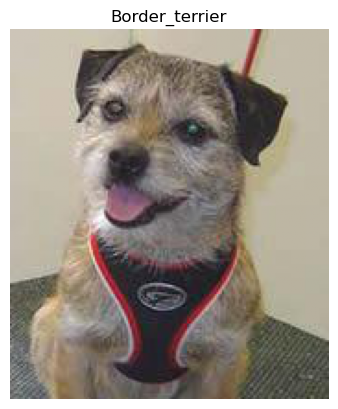

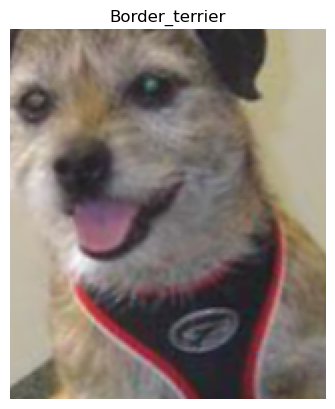

In [8]:
target_class = random.choice(class_names)
random_image = f'{os.getcwd()}/data/{target_class}/{random.choice(os.listdir("data/"+target_class))}'
img1 = tf.io.read_file(random_image)

img_tensor = mping.imread(random_image)

plt.imshow(img_tensor/255.)
plt.title(f'{target_class}')
plt.axis(False);

img_augmented = data_augmentation(tf.expand_dims(img_tensor, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(img_augmented)/255.)
plt.title(f'{target_class}')
plt.axis(False);

In [38]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = False

input_shape = IMG_SIZE+(3,)

inputs = tf.keras.layers.Input(shape=input_shape, name="Input_layer")

x = data_augmentation(inputs)
x = base_model(inputs, training=False) # Pass the augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling_Layer")(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="Output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss= tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

43941136/43941136 [==============================] - 1s 0us/step


In [39]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 Global_Average_Pooling_Laye  (None, 1536)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 Output_layer (Dense)        (None, 129)               198273    
                                                                 
Total params: 10,981,808
Trainable params: 198,273
Non-trainable params: 10,783,535
_________________________________________________________________


In [40]:
# Set checkpoint path
checkpoint_path = "pechpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch")

early_stopper = tf.keras.callbacks.EarlyStopping(patience=3, 
                                                 restore_best_weights=True)

In [41]:
initial_epochs = 5
history_data_aug = model_1.fit(train_ds,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_ds),
                               validation_data = val_ds,
                               validation_steps= int(0.40 * len(val_ds)),
                               callbacks=[checkpoint_callback, early_stopper])

Epoch 1/5


2022-08-25 16:14:50.603828: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-25 16:14:50.609136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1825/1825 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.7968

2022-08-25 16:20:40.444615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.52236, saving model to pechpoints_weights/checkpoint.ckpt
1825/1825 [==============================] - 373s 202ms/step - loss: 0.7344 - accuracy: 0.7968 - val_loss: 0.5224 - val_accuracy: 0.8388
Epoch 2/5
1825/1825 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8531
Epoch 2: val_loss improved from 0.52236 to 0.50684, saving model to pechpoints_weights/checkpoint.ckpt
1825/1825 [==============================] - 368s 202ms/step - loss: 0.4458 - accuracy: 0.8531 - val_loss: 0.5068 - val_accuracy: 0.8375
Epoch 3/5
1825/1825 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.8761
Epoch 3: val_loss did not improve from 0.50684
1825/1825 [==============================] - 367s 201ms/step - loss: 0.3710 - accuracy: 0.8761 - val_loss: 0.5101 - val_accuracy: 0.8388
Epoch 4/5
1825/1825 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8920
Epoch 4: val_loss did not improve from 0.50684
1

In [42]:
# Unfreeze all of the layer in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-8]:
  layer.trainable = False

# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer= tf.keras.optimizers.Adam(1.0e-4),
                metrics=["accuracy"])

In [43]:
for layer in model_1.layers:
  print(layer.name, layer.trainable)

Input_layer True
efficientnetb3 True
Global_Average_Pooling_Layer True
Output_layer True


In [44]:
for layer_number, layer in enumerate(model_1.layers[1].layers):
  print(f"({layer_number}) {layer.name}: {layer.trainable}")

(0) input_1: False
(1) rescaling: False
(2) normalization: False
(3) tf.math.truediv: False
(4) stem_conv_pad: False
(5) stem_conv: False
(6) stem_bn: False
(7) stem_activation: False
(8) block1a_dwconv: False
(9) block1a_bn: False
(10) block1a_activation: False
(11) block1a_se_squeeze: False
(12) block1a_se_reshape: False
(13) block1a_se_reduce: False
(14) block1a_se_expand: False
(15) block1a_se_excite: False
(16) block1a_project_conv: False
(17) block1a_project_bn: False
(18) block1b_dwconv: False
(19) block1b_bn: False
(20) block1b_activation: False
(21) block1b_se_squeeze: False
(22) block1b_se_reshape: False
(23) block1b_se_reduce: False
(24) block1b_se_expand: False
(25) block1b_se_excite: False
(26) block1b_project_conv: False
(27) block1b_project_bn: False
(28) block1b_drop: False
(29) block1b_add: False
(30) block2a_expand_conv: False
(31) block2a_expand_bn: False
(32) block2a_expand_activation: False
(33) block2a_dwconv_pad: False
(34) block2a_dwconv: False
(35) block2a_bn: 

In [45]:
fine_tune_epochs = initial_epochs+5

history_fine_tune = model_1.fit(train_ds,
                                epochs=fine_tune_epochs,
                                initial_epoch= history_data_aug.epoch[-1],
                                validation_data = val_ds,
                                validation_steps= int(0.40 * len(val_ds)),
                                callbacks=[early_stopper])

Epoch 5/10


2022-08-25 16:50:14.939464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1825/1825 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8828

2022-08-25 16:56:15.806556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1825/1825 [==============================] - 384s 208ms/step - loss: 0.3456 - accuracy: 0.8828 - val_loss: 0.4903 - val_accuracy: 0.8416
Epoch 6/10
1825/1825 [==============================] - 372s 204ms/step - loss: 0.2635 - accuracy: 0.9113 - val_loss: 0.4936 - val_accuracy: 0.8428
Epoch 7/10
1825/1825 [==============================] - 371s 203ms/step - loss: 0.2077 - accuracy: 0.9325 - val_loss: 0.5151 - val_accuracy: 0.8375
Epoch 8/10
1825/1825 [==============================] - 372s 204ms/step - loss: 0.1662 - accuracy: 0.9460 - val_loss: 0.5252 - val_accuracy: 0.8328


In [46]:
model_1.evaluate(val_ds)

252/252 [==============================] - 51s 198ms/step - loss: 0.5046 - accuracy: 0.8354


[0.5045922994613647, 0.8354446291923523]

In [47]:
model_1.save(os.path.join(os.getcwd(),'saved_model.h5'))

In [20]:
saved_model = tf.keras.models.load_model(os.path.join(os.getcwd(),'saved_model.h5'))

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-26 00:05:46.104717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-26 00:05:46.104840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [49]:
saved_model.evaluate(val_ds)

2022-08-25 17:20:48.389466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - 52s 197ms/step - loss: 0.5046 - accuracy: 0.8354


[0.50459223985672, 0.8354446291923523]

In [35]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  from PIL import Image
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    img_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode image into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize our image
  img = tf.image.resize(img, [img_shape,img_shape])
  # Scale
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/225.
  else:
    return img # don't need to resclae images for EfficientNet models in Tensorflow

In [23]:
saved_model = tf.keras.models.load_model(os.path.join(os.getcwd(),'saved_model.h5'))

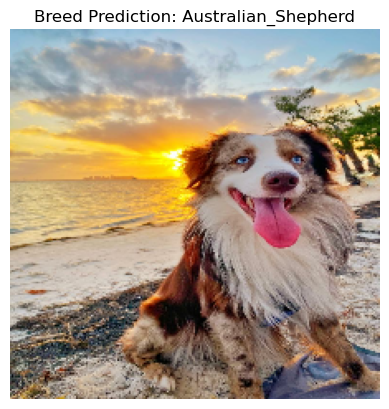

In [39]:
image_to_test = load_and_prep_image('/Users/femartinez/Desktop/lyanne.jpeg', scale=False)

prediction = saved_model.predict(tf.expand_dims(image_to_test, axis=0), verbose=0)
plt.imshow(image_to_test/255.)
plt.title(f'Breed Prediction: {class_names[str(tf.argmax(prediction, axis=1).numpy()[0])]}')
plt.axis(False);

In [37]:
tf.argmax(prediction, axis=1).numpy()

array([ 12,  27,   9,  80,  44, 119,  62])

In [280]:
test_preds = model_1.predict(val_ds, verbose=1)

2022-08-21 22:00:35.274009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


273/273 [==============================] - 46s 151ms/step


In [285]:
val_ds.class_names

['Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_Shepherd',
 'Australian_terrier',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'Bichon_Frise',
 'Black_sable',
 'Blenheim_spaniel',
 'Border_collie',
 'Border_terrier',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'Brabancon_griffo',
 'Brittany_spaniel',
 'Cane_Carso',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Chinese_Crested_Dog',
 'Dandie_Dinmont',
 'Doberman',
 'English_foxhound',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'Fila Braziliero',
 'French_bulldog',
 'German_shepherd',
 'German_short_haired_pointer',
 'Gordon_setter',
 'Great_Dane',
 'Great_Pyrenees',
 'Greater_Swiss_Mountain_dog',
 'Ibizan_hound',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_spaniel',
 'Irish_wolfhound',
 'Italian_greyhound',
 'Japanese_Spitzes',
 'Japanese_spaniel',
 'Kerry_blue_terrier',
 'Labrador_retriever',
 'Lakeland_terrier',
 'Leon

In [283]:
tf.argmax(test_preds,axis=1)

<tf.Tensor: shape=(8722,), dtype=int64, numpy=array([103, 104,  65, ..., 123,  45,  33])>

In [6]:
import os

In [157]:
tf.argmax(prediction,axis=1).numpy()[0]

5

In [8]:
from pathlib import Path
os.path.join(Path('__file__').parent.absolute(), 'mogola')

'/Users/femartinez/Documents/Dog_breeds_project/Dog_Breeds_App/model/mogola'